In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [14]:
top1000_imdb_movies = pd.read_csv("data/scrap/top1000_IMDB_movies.csv")
cmu_movies = pd.read_csv('data/cmu_movies.csv', sep='\t')
metacritic_reviews = pd.read_csv('data/scrap/metacritic_reviews.csv')

In [4]:
# Filter movies with metacritic reviews and freebase id
alldata_movies = top1000_imdb_movies.loc[(top1000_imdb_movies['freebase_id'].isin(cmu_movies['freebase_id'])) & (top1000_imdb_movies['metacritic_id'].isin(metacritic_reviews['metacritic_id']))]

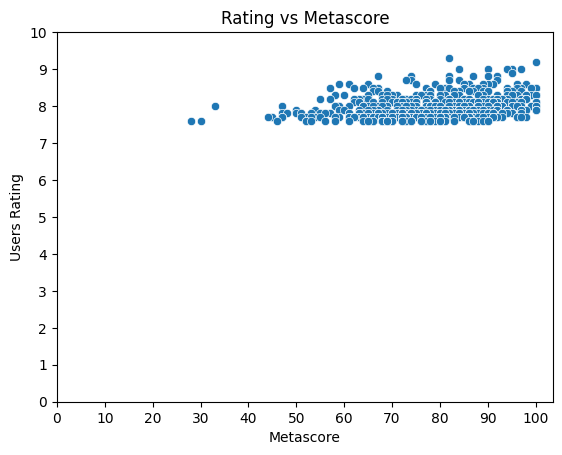

In [5]:
sns.scatterplot(x="metascore", y="rating", data=alldata_movies)
plt.title("Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlabel("Metascore")
plt.ylabel("Users Rating")
plt.show()

In [110]:
top_publishers = metacritic_reviews \
    .groupby('publisher') \
    .agg({'rating': ['count']}) \
    .sort_values(by=[('rating', 'count')], ascending=False) \
    .head(20) \
    .reset_index() \
    ['publisher']

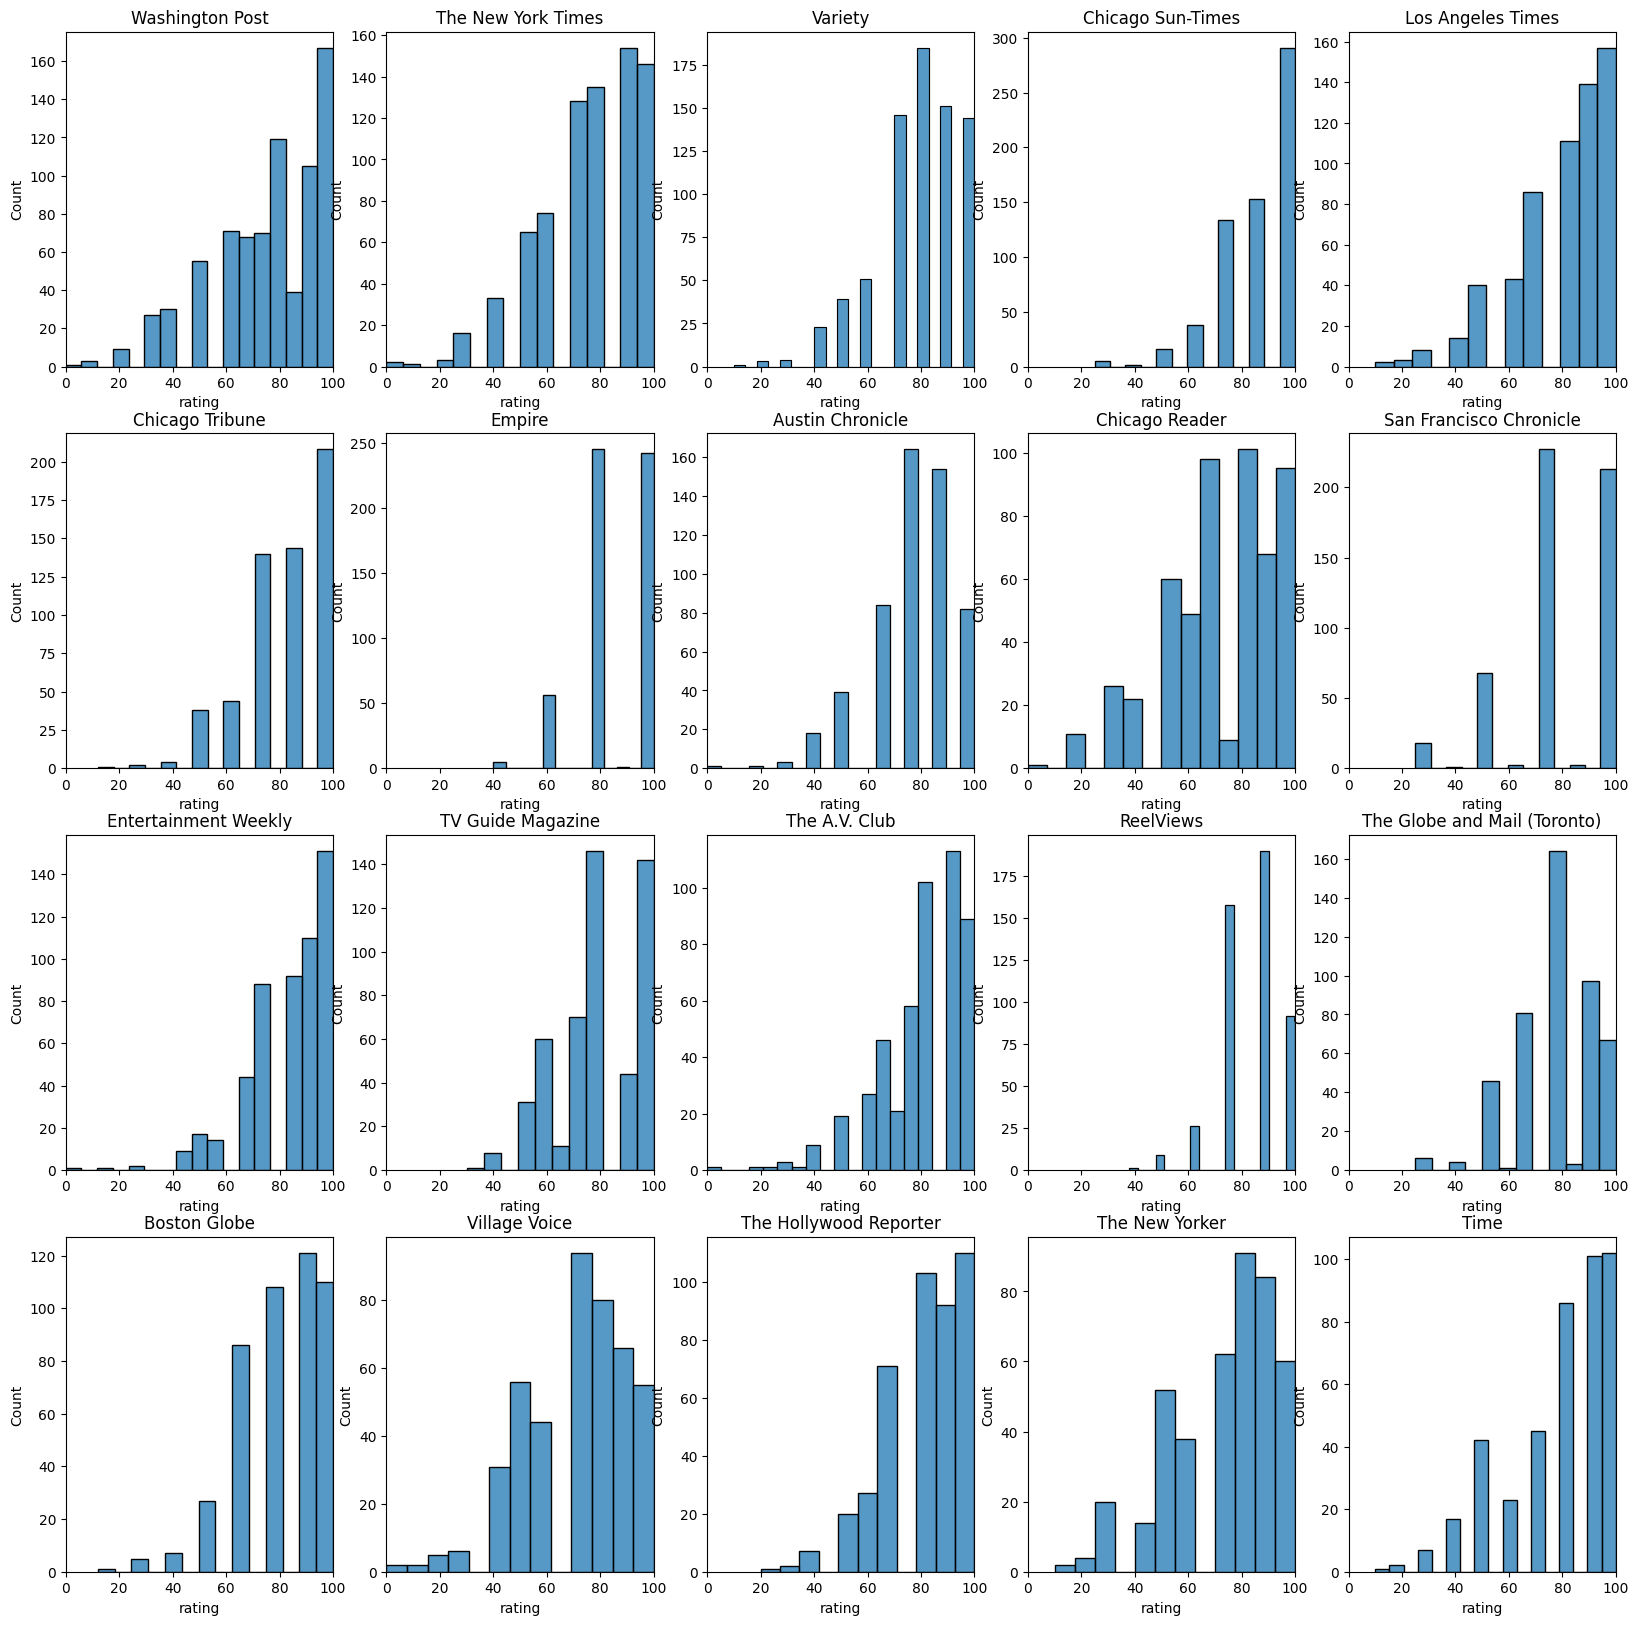

In [116]:
# create one subplot for each publisher
fig, axs = plt.subplots(len(top_publishers) // 5, 5, figsize=( 20, (len(top_publishers) // 5) * 5))

# plot the distribution of ratings for each publisher
for i, publisher in enumerate(top_publishers):
    ax = axs[i // 5][i % 5]
    ax.set_title(publisher)
    sns.histplot(metacritic_reviews.loc[metacritic_reviews['publisher'] == publisher]['rating'], ax=ax)
    ax.set_xlim(0, 100)

plt.show()


In [38]:
merged_metacritic_reviews = metacritic_reviews.merge(cmu_movies.loc[(cmu_movies['metacritic_id'].isin(metacritic_reviews['metacritic_id'])) & ~(cmu_movies['metacritic_id'].isna()), ('metacritic_id', 'genres')], on='metacritic_id', how='left')

In [56]:
# Assuming 'merged_metacritic_reviews' is your DataFrame
def extract_genres(row):
    try:
        genres_dict = ast.literal_eval(row['genres'])
        return list(genres_dict.values())
    except:
        return []
    

# Apply the function to extract genres
merged_metacritic_reviews['extracted_genres'] = merged_metacritic_reviews.apply(extract_genres, axis=1)

# Explode the DataFrame to have a separate row for each genre
exploded_df = merged_metacritic_reviews.explode('extracted_genres')

# Group by genre and calculate mean and count of ratings
grouped_df = exploded_df.groupby('extracted_genres').agg({'rating': ['mean', 'count']})

# Sort by the count of ratings and take the top 10
top_genres = grouped_df.sort_values(by=('rating', 'mean'), ascending=False).head(10)

In [79]:
# select one occurence per movie
exploded_df.groupby('extracted_genres').agg({'rating': ['mean', 'count']}).sort_values(by=('rating', 'mean'), ascending=False)

rating      
                              mean count
extracted_genres                        
Propaganda film          94.772727    22
Jungle Film              93.866667    15
Mockumentary             91.966667    30
Alien invasion           90.687500    16
Sword and sorcery films  89.885965   114
...                            ...   ...
Live action              49.846154    13
Film à clef              43.922078    77
Star vehicle             40.384615    39
Demonic child            38.023256    43
Legal drama              37.454545    44

[209 rows x 2 columns]

In [81]:
exploded_df.loc[exploded_df['extracted_genres'] == 'Film à clef']['metacritic_id'].unique()

array(['movie/citizen-kane', 'movie/sweet-smell-of-success', 'movie/rope'],
      dtype=object)

In [82]:
cmu_movies.loc[cmu_movies['metacritic_id'].isin(exploded_df.loc[exploded_df['extracted_genres'] == 'Film à clef']['metacritic_id'].unique())]

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,imdb_id,metacritic_id
11046,5224,/m/01lsl,Citizen Kane,1941-05-01,1585634.0,119.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/09glv8x"": ""Film \u00e0 clef"", ""/m/06l3bl""...",tt0033467,movie/citizen-kane
61059,76371,/m/0k4gy,Sweet Smell of Success,1957,2250000.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3nby"": ""Media Satire"", ""/m/07s9rl0"": ""...",tt0051036,movie/sweet-smell-of-success
73683,23477436,/m/0k0rf,Rope,1948,NaN,81.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hn10"": ""LGBT"", ""/m/01jfsb"": ""Thriller"", ...",tt0040746,movie/rope
